## 신경망의 구현 과정
***1*** | **환경 변수 지정**:  데이터셋(입력 값, 결괏값),
     학습률, 활성화 함수, 가중치 포함.
<br>
***2*** | **신경망 실행**: 초기값 입력 -> 활성화 함수, 가중치 -> 결과값
<br>
***3*** | **결과를 실제 값과 비교**: 오차 측정
<br>
***4*** | **역전파 실행**: 출력층, 은닉층의 가중치 수정
<br>
***5*** | **결과 출력**

## 라이브러리 import

In [ ]:
import random
import numpy as np

random.seed(777) # 시드: 난수 생성기를 초기화해주는 역할

## 환경 변수 지정

In [ ]:
# 입력값 및 타겟값 (XOR 진리표 활용)
# 두 개의 입력 값과 한개의 타깃 값
data = [
    [[0, 0], [1]],
    [[0, 1], [1]],
    [[1, 0], [1]],
    [[1, 1], [0]]
]

# 실행 횟수(iterations), 학습률(lr), 모멘텀 계수(mo) 설정
iterations=5000
lr=0.1
mo=0.4

### 활성화 함수, 초기 가중치 지정

1. 시그모이드 함수와 하이퍼볼릭 탄젠트 함수 생성
2. 미분 적용 여부 결정
3. 가중치가 들어갈 배열 함수 생성

In [ ]:
# 활성화 함수 - 1. 시그모이드
# 미분할 때와 아닐 때의 각각의 값
def sigmoid(x, derivative=False):
    if (derivative == True):
        return x * (1 - x)
    return 1 / (1 + np.exp(-x))

# 활성화 함수 - 2. tanh
# tanh 함수의 미분은 1 - (활성화 함수 출력의 제곱)
def tanh(x, derivative=False):
    if (derivative == True):
        return 1 - x ** 2
    return np.tanh(x)

# 가중치 배열 만드는 함수
def makeMatrix(i, j, fill=0.0):
    mat = []
    for i in range(i):
        mat.append([fill] * j)
    return mat

## 신경망의 실행

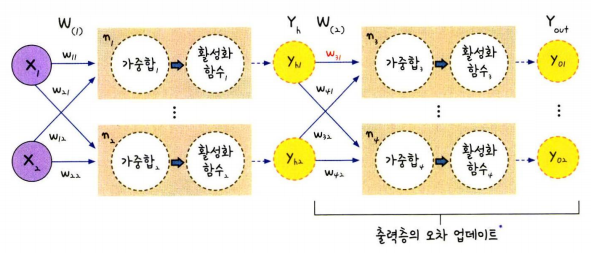

신경망 실행 클래스: 초기값 지정, 업데이트 함수, 역전파 함수

In [ ]:
class NeuralNetwork:

    # 초깃값의 지정
    def __init__(self, num_x, num_yh, num_yo, bias=1):

        # 입력값(num_x), 은닉층 초깃값(num_yh), 출력층 초깃값(num_yo), 바이어스
        self.num_x = num_x + bias  # 바이어스는 1로 지정(본문 참조)
        self.num_yh = num_yh 
        self.num_yo = num_yo 

        # 활성화 함수 초깃값
        self.activation_input = [1.0] * self.num_x
        self.activation_hidden = [1.0] * self.num_yh
        self.activation_out = [1.0] * self.num_yo

        # 가중치 입력 초깃값
        self.weight_in = makeMatrix(self.num_x, self.num_yh) # i는 입력값, j는 은닉층 초깃값 -> 0인 배열
        for i in range(self.num_x):
            for j in range(self.num_yh):
                self.weight_in[i][j] = random.random() # 랜덤 값 대입


        # 가중치 출력 초깃값
        self.weight_out = makeMatrix(self.num_yh, self.num_yo) # i는 은닉층 초깃값, j는 출력층 초깃값
        for j in range(self.num_yh):
            for k in range(self.num_yo):
                self.weight_out[j][k] = random.random()

        # SGD를 위한 이전 가중치 초깃값
        # SGD: 확률적 경사하강법: 랜덤하게 추출한 데이터를 사용해 더 빨리, 자주 업데이트를 하게 하는 것
        self.gradient_in = makeMatrix(self.num_x, self.num_yh)
        self.gradient_out = makeMatrix(self.num_yh, self.num_yo)

    # 업데이트 함수(각 층의 업데이트)
    def update(self, inputs):

        # 입력 레이어의 활성화 함수
        for i in range(self.num_x - 1):
            self.activation_input[i] = inputs[i] # [0, 0], [1, 0]...

        # 은닉층의 활성화 함수 -> 은닉층 출력값
        for j in range(self.num_yh):
            sum = 0.0
            for i in range(self.num_x):
                sum = sum + self.activation_input[i] * self.weight_in[i][j]
            # 시그모이드와 tanh 중에서 활성화 함수 선택
            self.activation_hidden[j] = tanh(sum, False)

        # 출력층의 활성화 함수 -> 출력층 값
        for k in range(self.num_yo):
            sum = 0.0
            for j in range(self.num_yh):
                sum = sum + self.activation_hidden[j] * self.weight_out[j][k]
            # 시그모이드와 tanh 중에서 활성화 함수 선택
            self.activation_out[k] = tanh(sum, False)
        
        # 반환 값: 출력 값(예측 값)
        return self.activation_out[:]
    
    # 역전파의 실행(가중치 업데이트)
    def backPropagate(self, targets):

        # 델타 출력 계산
        output_deltas = [0.0] * self.num_yo
        for k in range(self.num_yo):
            error = targets[k] - self.activation_out[k] # 실제 값 - 출력 값(예측)
            # 시그모이드와 tanh 중에서 활성화 함수 선택, 미분 적용
            output_deltas[k] = tanh(self.activation_out[k], True) * error
            # 출력 델타 값 = 미분된 tanh(출력 값) * 오차

        # 은닉 노드의 오차 함수
        hidden_deltas = [0.0] * self.num_yh
        for j in range(self.num_yh):
            error = 0.0
            for k in range(self.num_yo):
                error = error + output_deltas[k] * self.weight_out[j][k] # 기존 error + (델타 * 출력 가중치)
                # 시그모이드와 tanh 중에서 활성화 함수 선택, 미분 적용
            hidden_deltas[j] = tanh(self.activation_hidden[j], True) * error
            # 은닉층의 델타 값 = 미분한 tanh(은닉층의 출력값) * 오차

        # 출력 가중치 업데이트
        for j in range(self.num_yh):
            for k in range(self.num_yo):
                gradient = output_deltas[k] * self.activation_hidden[j] # 변화율 = 출력 델타 값 * 은닉층 출력 값
                v = mo * self.gradient_out[j][k] - lr * gradient # 가중치 = 기존 가중치  - 학습률 * 변화율
                # 출력 가중치, 출력 그래디언트 업데이트
                self.weight_out[j][k] += v
                self.gradient_out[j][k] = gradient

        # 입력 가중치 업데이트
        for i in range(self.num_x):
            for j in range(self.num_yh):
                gradient = hidden_deltas[j] * self.activation_input[i] # 변화율 = 은닉 델타 값 * 입력 레이어의 값
                v = mo*self.gradient_in[i][j] - lr * gradient
                # 입력 가중치, 입력 그래디언트 업데이트
                self.weight_in[i][j] += v
                self.gradient_in[i][j] = gradient
        

        # 오차의 계산(최소 제곱법)
        # (1/2) * (결과 값 - 출력 값)^2
        error = 0.0
        for k in range(len(targets)):
            error = error + 0.5 * (targets[k] - self.activation_out[k]) ** 2
        return error

    # 학습 실행
    def train(self, patterns):
        for i in range(iterations):
            error = 0.0
            for p in patterns:
                inputs = p[0] # 입력 값
                targets = p[1] # 결과 값
                self.update(inputs) # 입력 값을 통한 활성화 함수 업데이트
                error = error + self.backPropagate(targets)
            if i % 500 == 0:
                print('error: %-.5f' % error)
    # 결괏값 출력
    def result(self, patterns):
        for p in patterns:
            print('Input: %s, Predict: %s' % (p[0], self.update(p[0])))

if __name__ == '__main__':

    # 두 개의 입력 값, 두 개의 레이어, 하나의 출력 값을 갖도록 설정
    n = NeuralNetwork(2, 2, 1)

    # 학습 실행
    n.train(data)

    # 결괏값 출력
    n.result(data)


# Reference: http://arctrix.com/nas/python/bpnn.py (Neil Schemenauer)



error: 0.48858
error: 0.00141
error: 0.00058
error: 0.00035
error: 0.00025
error: 0.00020
error: 0.00016
error: 0.00014
error: 0.00012
error: 0.00010
Input: [0, 0], Predict: [0.9994638699521569]
Input: [0, 1], Predict: [0.9937824165328984]
Input: [1, 0], Predict: [0.9937849706066233]
Input: [1, 1], Predict: [-0.017539202518276942]


### 추가) 데이터 입력 값 변경(OR, AND)

